In [ ]:
import re
import numpy as np
import pandas as pd
import nltk
import torch
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import KeyedVectors
from transformers import BertTokenizer, BertModel
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

Pre-Traitement du Dataset

In [3]:
#LIRE LE DATASET

train = pd.read_csv('Dataset/training.csv')
test = pd.read_csv('Dataset/test.csv')
validate = pd.read_csv('Dataset/validation.csv')


#PRETRAITEMENT DU DATASET

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
valid_labels = [0, 1, 2, 3, 4]  


train = train[train['label'].isin(valid_labels)]
test = test[test['label'].isin(valid_labels)]
validate = validate[validate['label'].isin(valid_labels)]

def nettoyer(text):
    text = text.lower()
    # Supprimer les caractères spéciaux
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenisation
    words = nltk.word_tokenize(text)
    # Suppression des mots vides et lemmatisation
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Reconstituer le texte prétraité
    return words

test['text'] = test['text'].apply(nettoyer).tolist()
train['text'] = train['text'].apply(nettoyer).tolist()
validate['text'] = validate['text'].apply(nettoyer).tolist()


print("Corpus après prétraitement :\n", test[:5])

Corpus après prétraitement :
                                                 text  label
0  [im, feeling, rather, rotten, im, ambitious, r...      0
1                 [im, updating, blog, feel, shitty]      0
2  [never, make, separate, ever, want, feel, like...      0
3  [left, bouquet, red, yellow, tulip, arm, feeli...      1
4                       [feeling, little, vain, one]      0


Vectorisation Word2Vec

In [ ]:
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

def words_to_embedding_sequence(words, model, max_sequence_length):
    embeddings = [model[word] if word in model else np.zeros(model.vector_size) for word in words]
    while len(embeddings) < max_sequence_length:
        embeddings.append(np.zeros(model.vector_size))
    return embeddings[:max_sequence_length]

def process_dataset(dataset, column, model, max_sequence_length):
    return np.array([words_to_embedding_sequence(words, model, max_sequence_length) for words in dataset[column]])

max_sequence_length = 66
x_train = process_dataset(train, 'text', word2vec_model , max_sequence_length)
x_test = process_dataset(test, 'text', word2vec_model, max_sequence_length)
x_validate = process_dataset(validate, 'text',word2vec_model, max_sequence_length)

# Convertir les labels en one-hot encoding
y_train = to_categorical(train['label'], num_classes=5)
y_test = to_categorical(test['label'], num_classes=5)
y_validate = to_categorical(validate['label'], num_classes=5)

Vectorisation GLOVE

In [ ]:
# Charger les embeddings GloVe
def load_glove_embeddings(file_path, vector_size=300):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

glove_file = "glove.6B/glove.6B.300d.txt"  # Chemin vers le fichier GloVe
glove_embeddings = load_glove_embeddings(glove_file)

# Transformer les mots en séquences d'embeddings avec padding
def words_to_embedding_sequence(words, embeddings, max_sequence_length):
    vectors = [embeddings[word] if word in embeddings else np.zeros(len(next(iter(embeddings.values())))) for word in words]
    while len(vectors) < max_sequence_length:
        vectors.append(np.zeros(len(next(iter(embeddings.values())))))
    return vectors[:max_sequence_length]

# Traiter le dataset pour obtenir des séquences d'embeddings
def process_dataset(dataset, column, embeddings, max_sequence_length):
    return np.array([words_to_embedding_sequence(words, embeddings, max_sequence_length) for words in dataset[column]])

# Paramètres
max_sequence_length = 66
vector_size = 300  # Taille des vecteurs dans GloVe (par exemple, 300 pour glove.6B.300d.txt)

# Appliquer aux datasets
x_train = process_dataset(train, 'text', glove_embeddings, max_sequence_length)
x_test = process_dataset(test, 'text', glove_embeddings, max_sequence_length)
x_validate = process_dataset(validate, 'text', glove_embeddings, max_sequence_length)

# Convertir les labels en one-hot encoding
y_train = to_categorical(train['label'], num_classes=5)
y_test = to_categorical(test['label'], num_classes=5)
y_validate = to_categorical(validate['label'], num_classes=5)

Vectorisation FastText

In [ ]:

fasttext_model_path = 'wiki-news-300d-1M.vec'
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

def words_to_embedding_sequence(words, embeddings, max_sequence_length):
    vectors = [embeddings[word] if word in embeddings else np.zeros(embeddings.vector_size) for word in words]
    while len(vectors) < max_sequence_length:
        vectors.append(np.zeros(embeddings.vector_size))
    return vectors[:max_sequence_length]

# Traiter le dataset pour obtenir des séquences d'embeddings
def process_dataset(dataset, column, embeddings, max_sequence_length):
    return np.array([words_to_embedding_sequence(words, embeddings, max_sequence_length) for words in dataset[column]])

# Paramètres
max_sequence_length = 66
vector_size = 300  # Taille des vecteurs dans GloVe (par exemple, 300 pour glove.6B.300d.txt)

# Appliquer aux datasets
x_train = process_dataset(train, 'text', fasttext_model, max_sequence_length)
x_test = process_dataset(test, 'text', fasttext_model, max_sequence_length)
x_validate = process_dataset(validate, 'text', fasttext_model, max_sequence_length)

# Convertir les labels en one-hot encoding
y_train = to_categorical(train['label'], num_classes=5)
y_test = to_categorical(test['label'], num_classes=5)
y_validate = to_categorical(validate['label'], num_classes=5)

Vectorisation Bert (Transformers)

In [ ]:
# Load the BERT tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

def batch_to_embedding_sequences(batch_sentences, tokenizer, model, max_sequence_length=66):
    # Ensure sentences are strings (reconstruct from tokenized words if necessary)
    batch_sentences = [" ".join(sentence) if isinstance(sentence, list) else sentence for sentence in batch_sentences]
    
    # Encode inputs with tokenizer
    encoded_input = tokenizer(
        batch_sentences,
        truncation=True,
        padding='max_length',
        max_length=max_sequence_length,
        return_tensors="pt"
    )
    input_ids = encoded_input["input_ids"]
    attention_mask = encoded_input["attention_mask"]
    
    # Get BERT embeddings
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, max_sequence_length, embedding_dim)

    return last_hidden_state.cpu().numpy()  # Convert to NumPy array

def process_dataset_in_batches(dataset, column, tokenizer, model, max_sequence_length=66, batch_size=32):
    all_embeddings = []
    num_batches = len(dataset) // batch_size + (1 if len(dataset) % batch_size != 0 else 0)

    for i in range(num_batches):
        # Fetch batch sentences and ensure they are in string format
        batch_sentences = dataset[column][i * batch_size:(i + 1) * batch_size].tolist()
        batch_embeddings = batch_to_embedding_sequences(batch_sentences, tokenizer, model, max_sequence_length)
        all_embeddings.append(batch_embeddings)

    return np.vstack(all_embeddings)  # Combine all batches into a single NumPy array

# Process the datasets
x_train = process_dataset_in_batches(train, 'text', tokenizer, bert_model, max_sequence_length=66, batch_size=32)
x_test = process_dataset_in_batches(test, 'text', tokenizer, bert_model, max_sequence_length=66, batch_size=32)
x_validate = process_dataset_in_batches(validate, 'text', tokenizer, bert_model, max_sequence_length=66, batch_size=32)

# Convertir les labels en one-hot encoding
y_train = to_categorical(train['label'], num_classes=5)
y_test = to_categorical(test['label'], num_classes=5)
y_validate = to_categorical(validate['label'], num_classes=5)


Creation du modele LSTM

In [9]:
def create_lstm_model(input_shape, num_classes, lstm_units=128):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

input_shape = (66, 300)
num_classes = 5
lstm_model = create_lstm_model(input_shape, num_classes)
lstm_model.summary()


Entrainement du modele et visualisation des resultats

Epoch 1/14
234/234 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.3774 - loss: 1.4071 - val_accuracy: 0.6212 - val_loss: 0.9974
Epoch 2/14
234/234 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - accuracy: 0.6692 - loss: 0.8941 - val_accuracy: 0.7150 - val_loss: 0.7276
Epoch 3/14
234/234 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.7452 - loss: 0.6883 - val_accuracy: 0.8218 - val_loss: 0.5186
Epoch 4/14
234/234 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.8446 - loss: 0.4742 - val_accuracy: 0.8254 - val_loss: 0.5013
Epoch 5/14
234/234 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step - accuracy: 0.8714 - loss: 0.3676 - val_accuracy: 0.8895 - val_loss: 0.3253
Epoch 6/14
234/234 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - accuracy: 0.9110 - loss: 0.2665 - val_accuracy: 0.8932 - val_loss: 0.3042
Epoch 7/14
234/234 ━━━━━━━━━━━━━━━━━━━━ 35s 151ms/step - accuracy: 0.9259 - loss: 0.2259 - val_accuracy: 0.9166 - val_loss: 0.2524
Epoch 8/14
234/234 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - accuracy: 0.9413 - loss: 0

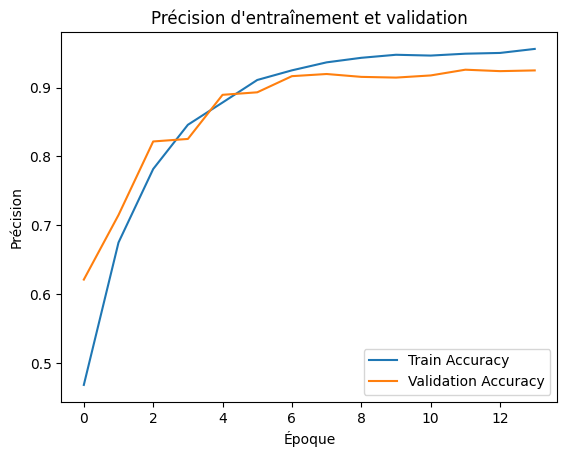

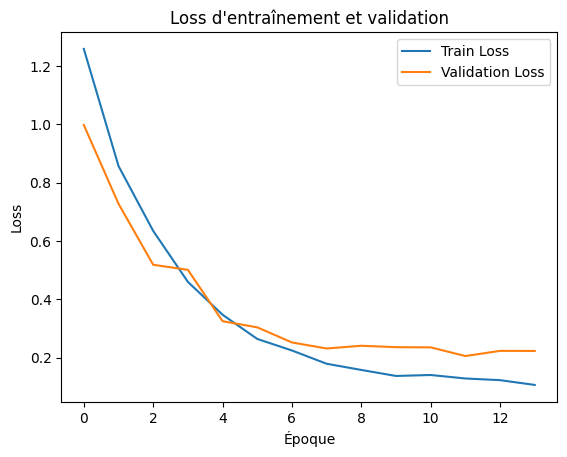

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9278 - loss: 0.2137
Test Loss: 0.2296, Test Accuracy: 0.9281
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Accuracy: 0.9281282316442606

Classification Report:

              precision    recall  f1-score   support

     sadness       0.97      0.94      0.95       581
         joy       0.92      0.95      0.93       695
        love       0.83      0.78      0.80       159
       anger       0.93      0.90      0.91       275
        fear       0.92      0.97      0.95       224

    accuracy                           0.93      1934
   macro avg       0.91      0.91      0.91      1934
weighted avg       0.93      0.93      0.93      1934



In [10]:
# Entraînement du modèle avec validation à chaque époque
history = lstm_model.fit(
    x_train, y_train,  # Données d'entraînement
    validation_data=(x_validate, y_validate),  # Données de validation
    epochs=14,  # Nombre d'époques
    batch_size=66  # Taille des lots
)

# Visualisation de l'accuracy d'entraînement et de validation
# Première courbe : Accuracy et Loss
plt.figure()  # Créer une nouvelle figure
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Précision d\'entraînement et validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.show()

# Deuxième courbe : Loss uniquement
plt.figure()  # Créer une nouvelle figure
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss d\'entraînement et validation')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Évaluation du modèle sur le jeu de test
test_loss, test_accuracy = lstm_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Prédictions sur le jeu de test
y_pred = lstm_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcul des métriques (accuracy, précision, rappel, F1-score)
print("Accuracy:", accuracy_score(y_true, y_pred_classes))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['sadness', 'joy', 'love', 'anger', 'fear']))

Sauvegarde du modele

In [12]:
# Save the model
lstm_model.save('lstm_model.keras')